In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import solve_for_masses as em
import mass_loss as ms
from numpy.random import normal
import math
%matplotlib inline

from importlib import reload

In [2]:
reload(ms)

<module 'mass_loss' from '/Users/bcamposestrada/Library/CloudStorage/OneDrive-UniversityofCopenhagen/EvapMass/mass_loss.py'>

To start with we need to make some basic choices. First we need to assume the composition of the solid cores. This uses the Fortney et al. (2007, ApJ 659 1661) mass-radius relation. They can either be iron-rock or water-rock (both the iron fraction and ice fraction cannot be non-zero). 

In [3]:
Xiron = 1./3.
Xice = 0.

As discussed in the paper (Owen & Campos Estrada, 2020), one needs to choose a Kelvin-Helmholtz timescale for the H/He atmospheres at which to do the comparision (i.e. at what age is mass-loss important), the answer is very weakly dependent on this value, here we pick the standard value of 100 Myr.

In [4]:
Tkh_Myr=100.

The location of the radius valley can be chosen. The default is set to 1.8 Rearth, but this is generally only true for sun-like stars (van Eylen et al. 2018). One should change the location of the valley accordingly (for example for M-dwarfs the valley is generally at smaller radii - see van Eylen et al. 2021). 

In [5]:
valley_loc = 1.8

A note on the efficiency parameter. The code contains three options for the efficiency parameter in the mass-loss models.

1. Option 1, is to use a constant efficiency parameter.
2. Option 2, is to use the scaling $\eta \propto v_{\rm esc}^{-2}$, where $v_{\rm esc}$ is the escape velocity from the planet's surface. This fit was provided in Owen & Wu (2017) as an approximation of the hydrodynamic models. It works well for typical sub-neptunes; however, fails when the escape temperature from the planet is smaller than the outflow temperature. In this case it overestimates the efficiency. This occurs for larger planets, or planet's where the minimum required core-mass is low. 
3. Option 3 (Default) is a full fit to the Owen & Jackson (2012) mass-loss rates. It provides a normalised value of the efficiency (scaled to the highest value in the table). For very puffy planets, photoevaporation does not occur, but rather Roche Lobe overflow (grey region in Figure 5 of Owen & Jackson 2012). If this happens the efficiency value is simply extrapolated at a constant value for the last hydrodyanmic one. 
4. Additional options - you are free to modify the "efficiency" function in mass_loss.py to include your own efficiency function

In [6]:
# set the efficiency option 
eff_option = 3

One can test the effect of different mass-loss efficiencies in the distribution by running the same procedure and setting "eff_option" to 1 or 2. See the Intro_notebook for more information on this.

# TOI-1468
Test the TOI-1468 system, age of star is uncertain between 1000 to 10000 Myr. Choose 5000 Myr therefore.
Parameters taken from Chaturvedi et al. (2022).

In [7]:
valley_loc = 1.5 #this is an M dwarf system, so this choice is more appropriate

In [8]:
#Define the stellar parameters of the system 
system_name = 'TOI-1468'
s_M = 0.339 # stellar mass,  solar masses
s_Mer = 0.011 # stellar mass error, solar masses
s_Teff = 3496. # Stellar effective temperature, K
s_Teffer = 25. # stellar effective temperature error, K
s_R = 0.344 # stellar radius, solar radii - note we should really use the MS radii but this is and example.
s_Rer = 0.005 # stellar radius error, solar radii 
s_age = 5000. # stellar age, Myr
s_age_er = 1000. #stellar age error, Myr

In [9]:
#Planets are stored in dictionaries

"""
Dictionary keys: 
r - planet radius, Earth radii
r_err - error on planetary radius
p - orbital period, days
p_err - orbital period error, make them symmetric
"""

planet_b = {"name":'b', "r": 1.280, "r_err": np.sqrt(0.038**2.+0.039**2.),
            "p": 1.8805136, "p_err": np.sqrt(0.0000024**2.+0.0000026**2.)}

planet_c = {"name":'c', "r": 2.064, "r_err": 0.044, 
            "p": 15.532482, "p_err": np.sqrt(0.000034**2.+0.000033**2.)}

planets = [planet_b, planet_c]

In [10]:
#igaseous is where indices of gaseous planets are stored
igaseous = []
# evaluate minimum mass for the mean value and print it
system = em.psystem(system_name)

system.star.mass = s_M
system.star.radius = s_R
system.star.Teff = s_Teff
system.star.age = s_age

for planet in planets:
    system.add_planet(planet['name'], planet['r'], planet['r_err'],
                      planet['p'], planet['p_err'])
    
system.update_planet_info()
system.above_or_below_valley(valley_loc)
system.mass_rocky(Xiron,Xice)

ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

irocky = system.index_rocky_to_scale #index of rocky planet which is hardest to strip

n_gaseous = 0 #counter for number of mini-Neptunes in system
nplanet = 0 #index of current planet
for planet in system.planets:
  if (planet.rocky_or_gaseous == 0):
    igaseous.append(nplanet)
    n_gaseous +=1
    Mout, flag = ms.min_mass_gaseous(system.planets[irocky],system.planets[nplanet],
                                     Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    Mmedian = np.copy(Mout)
    if (Mmedian > 0):
        print('Planet', planet.name, 'must have a minimum core mass of %.2f Mearth to be consistent with photoevaporation.' % Mmedian)
    elif (Mmedian == -5.0):
        print('Planet', planet.name, 'has a larger mass-loss timescale than super-Earth for < 0.1Mearth. Planet is consistent with photoevaporation.')
    elif (Mmedian == -2.0):
        print(r'No solution. Planet not consistent with photoevaporation with the set parameters.')
  nplanet +=1
  

Planet c must have a minimum core mass of 0.35 Mearth to be consistent with photoevaporation.


The 95% upper limit to be consistent with photoevaporation is 0.28355741162942383Mearth


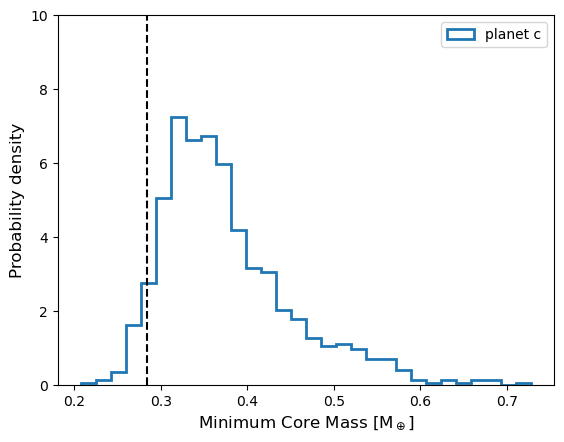

In [12]:
for index in igaseous:
  Mout_error= np.zeros(1000)
  flag_out = np.zeros(1000,dtype=np.int8)
    
  for i in range(np.size(Mout_error)):
    system = em.psystem(system_name+'_%d' %i)
    
    system.star.mass=normal(s_M,s_Mer,1)
    system.star.radius=normal(s_R,s_Rer,1)
    system.star.Teff=normal(s_Teff,s_Teffer,1)
    system.star.age = normal(s_age,s_age_er,1)
    
    for planet in planets:
        r_use = normal(planet['r'],planet['r_err'],1)
        p_use = normal(planet['p'],planet['p_err'],1)
        system.add_planet(planet['name'], r_use, planet['r_err'],
                          p_use, planet['p_err'])
    
    system.update_planet_info()
    system.above_or_below_valley(valley_loc)
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)
    irocky = system.index_rocky_to_scale #index of rocky planet which is hardest to strip
    

    Mout, flag = ms.min_mass_gaseous(system.planets[irocky],system.planets[index],
                                         Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    Mout_error[i] = Mout
    flag_out[i]=flag
  
  plt.hist(Mout_error,bins=30,density=True,histtype='step',lw=2, label='planet '+ system.planets[index].name) 
  #note if density=True this simply means are under the histogram is 1, not the height of the bars sums to 1!
  #plt.plot([8.08,8.08],[0.,1.],':',color='b', lw=1.5) #Must set this to the meassured mass of the planet
  plt.plot([(np.percentile(Mout_error,5.)),(np.percentile(Mout_error,5.))],[0.,10.],'--',color='k', lw=1.5)
  plt.ylim((0.,10.))
  plt.legend()
  plt.ylabel('Probability density',fontsize=12)
  plt.xlabel(r'Minimum Core Mass [M$_\oplus$]',fontsize=12)
  if (np.percentile(Mout_error,5.) == -5.0):
      print('The 95% upper limit to be consistent with photoevaporation is <0.1Mearth.')
  elif (np.percentile(Mout_error,5.) == -2.0):
        print('Planet is not consistent with photoevaporation. The 95% upper limit indicates there is no solution.')
  else:
     print('The 95% upper limit to be consistent with photoevaporation is ' + str((np.percentile(Mout_error,5.)))+ ' Mearth')

The measured mass of TOI-1468c is 6.64 $\pm$ 0.68 M$_{\oplus}$ (Chaturvedi et al. ,2022). Therefore the planet is consistent with photoevaporation.

# K2-3
Test the K2-3 system. Parameters taken from Diamond-Lowe et al. 2022.

In [13]:
#Define the stellar parameters of the system 
system_name = 'K2-3'
s_M = 0.549 # stellar mass,  solar masses
s_Mer = np.sqrt(0.029**2.+0.027**2.) # stellar mass error, solar masses
s_Teff = 3896. # Stellar effective temperature, K
s_Teffer = 189. # stellar effective temperature error, K
s_R = 0.546 # stellar radius, solar radii - note we should really use the MS radii but this is and example.
s_Rer = 0.017 # stellar radius error, solar radii 
s_age = 6900. # stellar age, Myr
s_age_er = 4700. #stellar age error, Myr

In [14]:
#Planets are stored in dictionaries

"""
Dictionary keys: 
r - planet radius, Earth radii
r_err - error on planetary radius
p - orbital period, days
p_err - orbital period error, make them symmetric
"""

planet_b = {"name":'b', "r": 2.078, "r_err": np.sqrt(0.076**2.+0.067**2.),
            "p": 10.0546535, "p_err": np.sqrt(0.0000088**2.+0.0000091**2.)}

planet_c = {"name":'c', "r": 1.582, "r_err": np.sqrt(0.057**2.+0.051**2.), 
            "p": 24.646729, "p_err": np.sqrt(0.000044**2.+0.000042**2.)}


planet_d = {"name":'d', "r": 1.458, "r_err": np.sqrt(0.056**2.+0.051**2.), 
            "p": 44.55603, "p_err": np.sqrt(0.00013**2.+0.00012**2.)}

planets = [planet_b, planet_c, planet_d]

In [17]:
#igaseous is where indices of gaseous planets are stored
igaseous = []
# evaluate minimum mass for the mean value and print it
system = em.psystem(system_name)

system.star.mass = s_M
system.star.radius = s_R
system.star.Teff = s_Teff
system.star.age = s_age

for planet in planets:
    system.add_planet(planet['name'], planet['r'], planet['r_err'],
                      planet['p'], planet['p_err'])
    
system.update_planet_info()
system.above_or_below_valley(valley_loc)
system.mass_rocky(Xiron,Xice)

ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

irocky = system.index_rocky_to_scale #index of rocky planet which is hardest to strip

n_gaseous = 0 #counter for number of mini-Neptunes in system
nplanet = 0 #index of current planet
for planet in system.planets:
  if (planet.rocky_or_gaseous == 0):
    igaseous.append(nplanet)
    n_gaseous +=1
    Mout, flag = ms.min_mass_gaseous(system.planets[irocky],system.planets[nplanet],
                                     Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    Mmedian = np.copy(Mout)
    if (Mmedian > 0):
        print('Planet', planet.name, 'must have a minimum core mass of %.2f Mearth to be consistent with photoevaporation.' % Mmedian)
    elif (Mmedian == -5.0):
        print('Planet', planet.name, 'has a larger mass-loss timescale than super-Earth for < 0.1Mearth. Planet is consistent with photoevaporation.')
    elif (Mmedian == -2.0):
        print(r'No solution. Planet', planet.name,'not consistent with photoevaporation with the set parameters.')
  nplanet +=1
  

Planet b must have a minimum core mass of 10.32 Mearth to be consistent with photoevaporation.
No solution. Planet c not consistent with photoevaporation with the set parameters.


K2-3 is most likely  a system of 3 mini-Neptunes. The planetary densities obtained by Diamond-Lowe et al. (2022) indicate all the planets should be volatile rich. From the radius valley location for M dwarfs derived by van Eylen et al. 2021, this is plausible and therefore EvapMass should not be applied for this system as it does not include planets both above and below the valley. 

# TOI-270
Test the TOI-270 system. Parameters taken from van Eylen et al. 2021.

In [18]:
valley_loc = 1.5

In [19]:
#Define the stellar parameters of the system 
system_name = 'TOI-270'
s_M = 0.386 # stellar mass,  solar masses
s_Mer = 0.008 # stellar mass error, solar masses
s_Teff = 3506. # Stellar effective temperature, K
s_Teffer = 70. # stellar effective temperature error, K
s_R = 0.378 # stellar radius, solar radii - note we should really use the MS radii but this is an example.
s_Rer = 0.011 # stellar radius error, solar radii 
s_age = 5000. # stellar age, Myr
s_age_er = 5000. #stellar age error, Myr

In [20]:
#Planets are stored in dictionaries

"""
Dictionary keys: 
r - planet radius, Earth radii
r_err - error on planetary radius
p - orbital period, days
p_err - orbital period error, make them symmetric
"""

planet_b = {"name":'b', "r": 1.206, "r_err": 0.039,
            "p": 3.3601538, "p_err": 0.0000048}

planet_c = {"name":'c', "r": 2.355, "r_err": 0.064, 
            "p": 5.6605731, "p_err": 0.0000031}


planet_d = {"name":'d', "r": 2.133, "r_err": 0.058, 
            "p":  11.379573, "p_err": 0.000013}

planets = [planet_b, planet_c, planet_d]

In [21]:
#igaseous is where indices of gaseous planets are stored
igaseous = []
# evaluate minimum mass for the mean value and print it
system = em.psystem(system_name)

system.star.mass = s_M
system.star.radius = s_R
system.star.Teff = s_Teff
system.star.age = s_age

for planet in planets:
    system.add_planet(planet['name'], planet['r'], planet['r_err'],
                      planet['p'], planet['p_err'])
    
system.update_planet_info()
system.above_or_below_valley(valley_loc)
system.mass_rocky(Xiron,Xice)

ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

irocky = system.index_rocky_to_scale #index of rocky planet which is hardest to strip

n_gaseous = 0 #counter for number of mini-Neptunes in system
nplanet = 0 #index of current planet
for planet in system.planets:
  if (planet.rocky_or_gaseous == 0):
    igaseous.append(nplanet)
    n_gaseous +=1
    Mout, flag = ms.min_mass_gaseous(system.planets[irocky],system.planets[nplanet],
                                     Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    Mmedian = np.copy(Mout)
    if (Mmedian > 0):
        print('Planet', planet.name, 'must have a minimum core mass of %.2f Mearth to be consistent with photoevaporation.' % Mmedian)
    elif (Mmedian == -5.0):
        print('Planet', planet.name, 'has a larger mass-loss timescale than super-Earth for < 0.1Mearth. Planet is consistent with photoevaporation.')
    elif (Mmedian == -2.0):
        print(r'No solution. Planet not consistent with photoevaporation with the set parameters.')
  nplanet +=1

Planet c must have a minimum core mass of 1.60 Mearth to be consistent with photoevaporation.
Planet d must have a minimum core mass of 0.76 Mearth to be consistent with photoevaporation.


As expected, the minimum mass required for planet d to keep an atmopshere is lower than that of planet c, given planet d is further from the star.

The 95% upper limit to be consistent with photoevaporation is <0.1Mearth.
The 95% upper limit to be consistent with photoevaporation is <0.1Mearth.


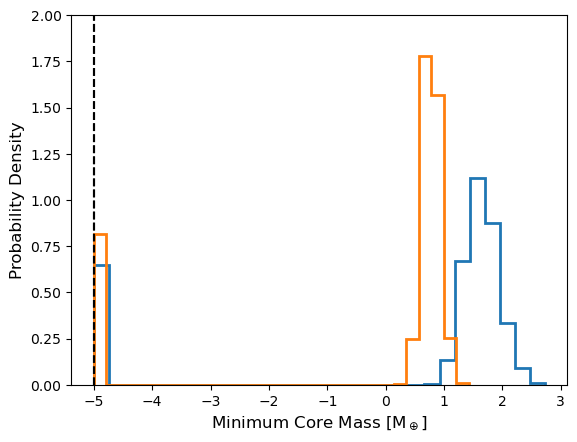

In [23]:
for index in igaseous:
  Mout_error= np.zeros(3000)
  flag_out = np.zeros(3000,dtype=np.int8)
    
  for i in range(np.size(Mout_error)):
    system = em.psystem(system_name+'_%d' %i)
    
    system.star.mass=normal(s_M,s_Mer,1)
    system.star.radius=normal(s_R,s_Rer,1)
    system.star.Teff=normal(s_Teff,s_Teffer,1)
    system.star.age = normal(s_age,s_age_er,1)
    
    for planet in planets:
        r_use = normal(planet['r'],planet['r_err'],1)
        p_use = normal(planet['p'],planet['p_err'],1)
        system.add_planet(planet['name'], r_use, planet['r_err'],
                          p_use, planet['p_err'])
    
    system.update_planet_info()
    system.above_or_below_valley(valley_loc)
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)
    irocky = system.index_rocky_to_scale #index of rocky planet which is hardest to strip
    

    Mout, flag = ms.min_mass_gaseous(system.planets[irocky],system.planets[index],
                                         Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    Mout_error[i] = Mout
    flag_out[i]=flag
    
  plt.hist(Mout_error,bins=30,density=True,histtype='step',lw=2, label='Planet '+ system.planets[index].name)
  plt.plot([(np.percentile(Mout_error,5.)),(np.percentile(Mout_error,5.))],[0.,2.],'--',color='k', lw=1.5)
  #plt.plot([8.08,8.08],[0.,2.],':',color='b', lw=1.5) #Must set this to the meassured mass of the planet
  plt.ylim((0.,2.))
  plt.ylabel('Probability Density',fontsize=12)
  plt.xlabel(r'Minimum Core Mass [M$_\oplus$]',fontsize=12)
  if (np.percentile(Mout_error,5.) == -5.0):
      print('The 95% upper limit to be consistent with photoevaporation is <0.1Mearth.')
  elif (np.percentile(Mout_error,5.) == -2.0):
        print('Planet is not consistent with photoevaporation. The 95% upper limit indicates there is no solution.')
  else:
     print('The 95% upper limit to be consistent with photoevaporation is ' + (np.percentile(Mout_error,5.))+ 'Mearth')

The TOI-270 system is consistent with photoevaporation as the measured mass of TOI-270c is 6.15 $\pm$ 0.37 M$_{\oplus}$ and the measured mass of TOI-270d is 4.18 $\pm$ 0.43 M$_{\oplus}$. Remember the -5 solution shown in the probability density graph simply indicates that the minimum mass obtained for those samples is less than 0.1M$_{\oplus}$.